# Validate SARIMAX on a given test/validation set on different strategies:
    1: Insample prediction
    2: Out of sample forecasting with recursion
    3: Out of sample forecasting considering new observation into account withot refitting SARIMAX on newly observed data
    3: Out of sample forecasting considering new observation into account with refitting SARIMAX on newly observed data
    enjoy it!!

## Libraries

In [1]:
# Author: Taylor Smith <taylor.smith@alkaline-ml.com>
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import train_test_split
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
from copy import deepcopy
from prettytable import PrettyTable
import sys
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

# '|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'
def validate_SARIMAX_on_split(y_train, y_validation, x_train=None, x_validation=None, prediction_step=12, SARIMAX_configs=None, **kwargs):
    '''
    y_train: y_train
    y_validation: y_validation
    x_train: exog train series
    x_validation: exog validation series
    prediction_step: the step to predict
    SARIMAX_configs: the configuration of SARIMAX model in dict format 
    '''
    
    # Train base SARIMAX model
    base_model = sm.tsa.SARIMAX(y_train, **SARIMAX_configs)
    base_model_fit = base_model.fit()
    
    # Initialize an empty list to store the predictions
    y_pred_base_model = pd.Series([])
    y_pred_base_model_on_train = pd.Series([])
    y_pred_updated_model = pd.Series([])
    y_pred_updated_model_refit = pd.Series([])
    
    # Define the prediction step for base model
    start, end = y_validation.index[prediction_step - 1], y_validation.index[-1]
    
    y_pred_base_model = base_model_fit.predict(start, end)
    # y_pred_base_model = base_model_fit.forecast(y_validation.size)
    y_pred_base_model_on_train = base_model_fit.predict(start= y_train.index[0], end=y_train.index[-1])
    
    updated_model_fit = deepcopy(base_model_fit)
    updated_model_refit_fit = deepcopy(base_model_fit)
    
    # for each two different ways was implemented to bu sure about the correctness of append function
    second_way = False
    if second_way:
        y_pred_updated_model_refit1 = pd.Series([])
        y_pred_updated_model1 = pd.Series([])
        walk_forward_train = y_train.copy()
        walk_forward_test = y_validation.copy()
        mod = sm.tsa.SARIMAX(y_train, **kwargs)
        res = mod.fit()
        history = y_train
    # main loop for validation
    for i in range(len(y_validation) - prediction_step + 1):
        sys.stdout.write("Progress: %d%%\r" % ((100*(i+1)/len(range(len(y_validation) - prediction_step + 1)))))
        sys.stdout.flush()
        # define the new observation
        new_observations = y_validation.iloc[i:i+1].copy()
        # new_observations.iloc[0]= new_observations.iloc[0] + np.random.randn(1) # only to test if the quality of refit and not is not as the same
    
        # forecasting with new observation without refit
        forecast_updated_model = updated_model_fit.forecast(steps=prediction_step).tail(1)
        y_pred_updated_model = pd.concat([y_pred_updated_model, forecast_updated_model], axis=0)
        updated_model_fit = updated_model_fit.append(new_observations, refit=False)
        # the second way   
        if second_way:
            forecast_updated_model1 = res.forecast(steps=prediction_step).tail(1)
            y_pred_updated_model1 = pd.concat([y_pred_updated_model1, forecast_updated_model1], axis=0)
            mod = sm.tsa.SARIMAX(history, **SARIMAX_configs)
            res = mod.filter(res.params)
            history = pd.concat([history, new_observations])
    
        # forecasting with new observation with refit
        forecast_updated_model_refit = updated_model_refit_fit.forecast(steps=prediction_step).tail(1)
        y_pred_updated_model_refit = pd.concat([y_pred_updated_model_refit, forecast_updated_model_refit], axis=0)
        updated_model_refit_fit = updated_model_refit_fit.append(new_observations, refit=True)
        # the second way
        if second_way:
            walk_forward_train[walk_forward_test.index[0]] = walk_forward_test.iloc[0]
            walk_forward_test.drop(walk_forward_test.index[0], inplace=True)
            base_model = sm.tsa.SARIMAX(walk_forward_train, **SARIMAX_configs)
            base_model_fit = base_model.fit()
            forecast_updated_model_refit1 = base_model_fit.forecast(steps=prediction_step).tail(1)
            y_pred_updated_model_refit1 = pd.concat([y_pred_updated_model_refit1, forecast_updated_model_refit], axis=0)
    # return predictions
    preds={'Insample': y_pred_base_model_on_train,
           'Recursive': y_pred_base_model,
           'With_new_observation': y_pred_updated_model,
           'Refit_with_new_observation': y_pred_updated_model_refit
          }           
    return preds
# '|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'
def plot_SARIMAX_preds_on_split(y_train, y_validation, preds):
    second_way = False
    y_pred_base_model_on_train = preds['Insample']
    y_pred_base_model = preds['Recursive']
    y_pred_updated_model = preds['With_new_observation']
    y_pred_updated_model_refit = preds['Refit_with_new_observation']

    train_display_lag = 50
    plt.figure(figsize=(10,5));
    ax = y_train[-train_display_lag:].plot(label='y_train', linestyle = '-', color='C0', title='Forecasting plot')
    y_validation.plot(ax=ax, label='y_validation', color='C0', linestyle = '--')
    y_pred_base_model_on_train[-train_display_lag:].plot(ax = ax, label='Insample', color='C2', linestyle = '-')
    y_pred_base_model.plot(ax = ax, label='Recursive', color='C1', linestyle = '-')
    y_pred_updated_model.plot(ax = ax, label='With new observation', color='C7', linestyle = '-')
    y_pred_updated_model_refit.plot(ax = ax, label='Refit with new observation', color='C3', linestyle = '-')
    if second_way: y_pred_updated_model1.plot(ax = ax, label='With new observation (2)', color='C8', linestyle = '-')
    if second_way: y_pred_updated_model_refit1.plot(ax = ax, label='Refit with new observation (2)', color='C9', linestyle = '-')
    # plt.fill_between(y_pred_updated_model.index,
    #                  y_validation.iloc[prediction_step - 1:],
    #                  y_pred_updated_model,
    #                  color='C7',
    #                  alpha=0.15)
    # plt.fill_between(y_pred_updated_model.index,
    #                  y_validation.iloc[prediction_step - 1:],
    #                  y_pred_updated_model_refit,
    #                  color='C3',
    #                  alpha=0.15)
    plt.axvline(y_train.index[-1], linestyle=':', label='End of training', color='C5')
    plt.axvline(y_validation.index[prediction_step - 1], linestyle=':', label='Start of forecasting', color='C6')
    ax.legend();
    plt.figure();
    (y_train - y_pred_base_model_on_train)[10:].plot.kde(label='Insample', color='C2')
    ax = (y_validation - y_pred_base_model).plot.kde(label='Recursive', title='Residuals KDE plot',  color='C1')
    (y_validation - y_pred_updated_model).plot.kde(label='With new observation', color='C7')
    (y_validation - y_pred_updated_model_refit).plot.kde(label='Refit with new observation', color='C3')
    ax.legend(loc='upper left');
# '|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'
def score(y_pred, y_validation, y_train, disp=True, **kwrgs):
    # Mean Absolute Error (MAE)
    metrics = {}
    mae = (y_pred - y_validation).abs().mean()
    metrics['MAE'] = mae
    # Root Mean Squared Error (RMSE)
    mse = ((y_pred - y_validation) ** 2).mean()
    rmse = np.sqrt(mse)
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse
    # Mean Absolute Percentage Error (MAPE)
    mape = (((y_pred - y_validation) / y_validation).abs()).mean() * 100
    metrics['MAPE'] = mape
    # mean absolute scaled error (MASE)
    train_mae =y_train.diff(1).abs().mean()
    mase = mae/train_mae
    metrics['MASE'] = mase
    # Root mean squared scaled error (RMSSE)
    train_mse = (y_train.diff(1) ** 2).mean()
    rmsse = np.sqrt(mse/train_mse)
    metrics['RMSSE'] = rmsse
    # R squared
    r2 =  1 - (((y_pred - y_validation) ** 2).sum() / ((y_pred - y_pred.mean()) ** 2).sum())
    metrics['R2'] = r2
    if disp:
        header = [metric for metric in metrics.keys()]
        values = [np.round(value, 2) for value in metrics.values()]
        table = PrettyTable(header)
        table.add_row(values)
        print(table)
    return metrics
# '|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'
def score_SARIMAX_preds_on_split(preds, y_validation, y_train, disp=True, **kwrgs):
    mets = []
    if disp: print('Insample')
    mets.append({'method' : 'Insample',
     'metrics' : score(preds['Insample'], y_train, y_train, disp=disp, **kwrgs)})
    
    if disp: print('Recursive')
    mets.append({'method' : 'Recursive',
     'metrics' : score(preds['Recursive'], y_validation, y_train, disp=disp, **kwrgs)})
    
    if disp: print('With_new_observation')
    mets.append({'method' : 'With_new_observation',
     'metrics' : score(preds['With_new_observation'], y_validation, y_train, disp=disp, **kwrgs)})
    
    if disp: print('Refit_with_new_observation')
    mets.append({'method' : 'Refit_with_new_observation',
     'metrics' : score(preds['Refit_with_new_observation'], y_validation, y_train, disp=disp, **kwrgs)})
    
    header = [h for h in mets[0]['metrics'].keys()]
    methods = [m['method'] for m in mets]
    df = pd.DataFrame()
    v = []
    for h in header: 
        values = [h]
        for m in mets:
            values.append(m['metrics'][h])
        v.append(values)
    cols =['metric']
    cols.extend(methods)
    df = pd.DataFrame(data=v, columns=cols)
    df.set_index('metric', inplace=True)
    ncols = 3
    nrows = len(header) // ncols + 1
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=nrows)
    i = 0
    for row in df.index:
        ax = axes[i // ncols, i % ncols ]
        df.loc[row, :].plot.bar(ax=ax)
        ax.legend([str(row)])
        ax.grid(color='b', linestyle=':', linewidth=.2)
        ax.tick_params(labelrotation=10)
        i += 1
# '|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||'

## Main

Insample: 100%
+------+--------+-------+------+------+-------+------+
| MAE  |  MSE   |  RMSE | MAPE | MASE | RMSSE |  R2  |
+------+--------+-------+------+------+-------+------+
| 9.17 | 211.61 | 14.55 | 4.69 | 0.44 |  0.54 | 0.98 |
+------+--------+-------+------+------+-------+------+
Recursive
+-------+---------+-------+------+------+-------+------+
|  MAE  |   MSE   |  RMSE | MAPE | MASE | RMSSE |  R2  |
+-------+---------+-------+------+------+-------+------+
| 24.39 | 1013.08 | 31.83 | 5.23 | 1.16 |  1.18 | 0.67 |
+-------+---------+-------+------+------+-------+------+
With_new_observation
+-------+--------+------+------+------+-------+------+
|  MAE  |  MSE   | RMSE | MAPE | MASE | RMSSE |  R2  |
+-------+--------+------+------+------+-------+------+
| 13.94 | 331.25 | 18.2 | 3.18 | 0.66 |  0.68 | 0.95 |
+-------+--------+------+------+------+-------+------+
Refit_with_new_observation
+-------+--------+-------+------+------+-------+------+
|  MAE  |  MSE   |  RMSE | MAPE | MA

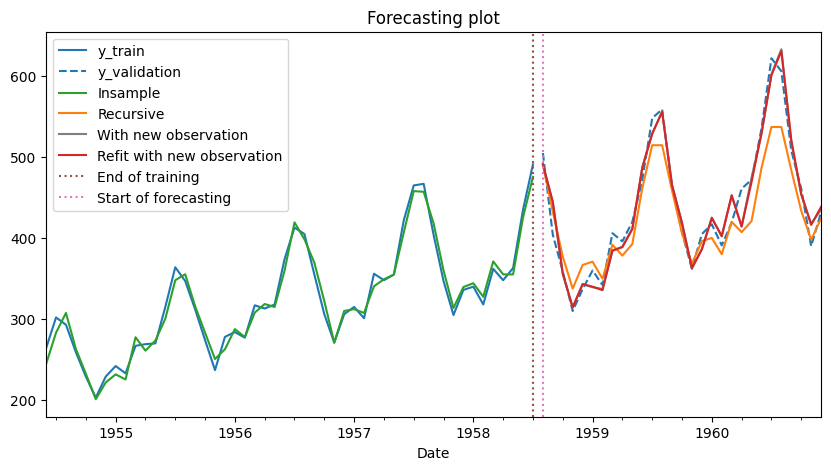

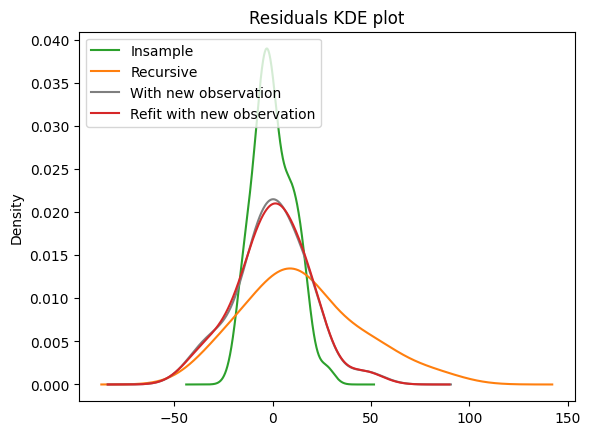

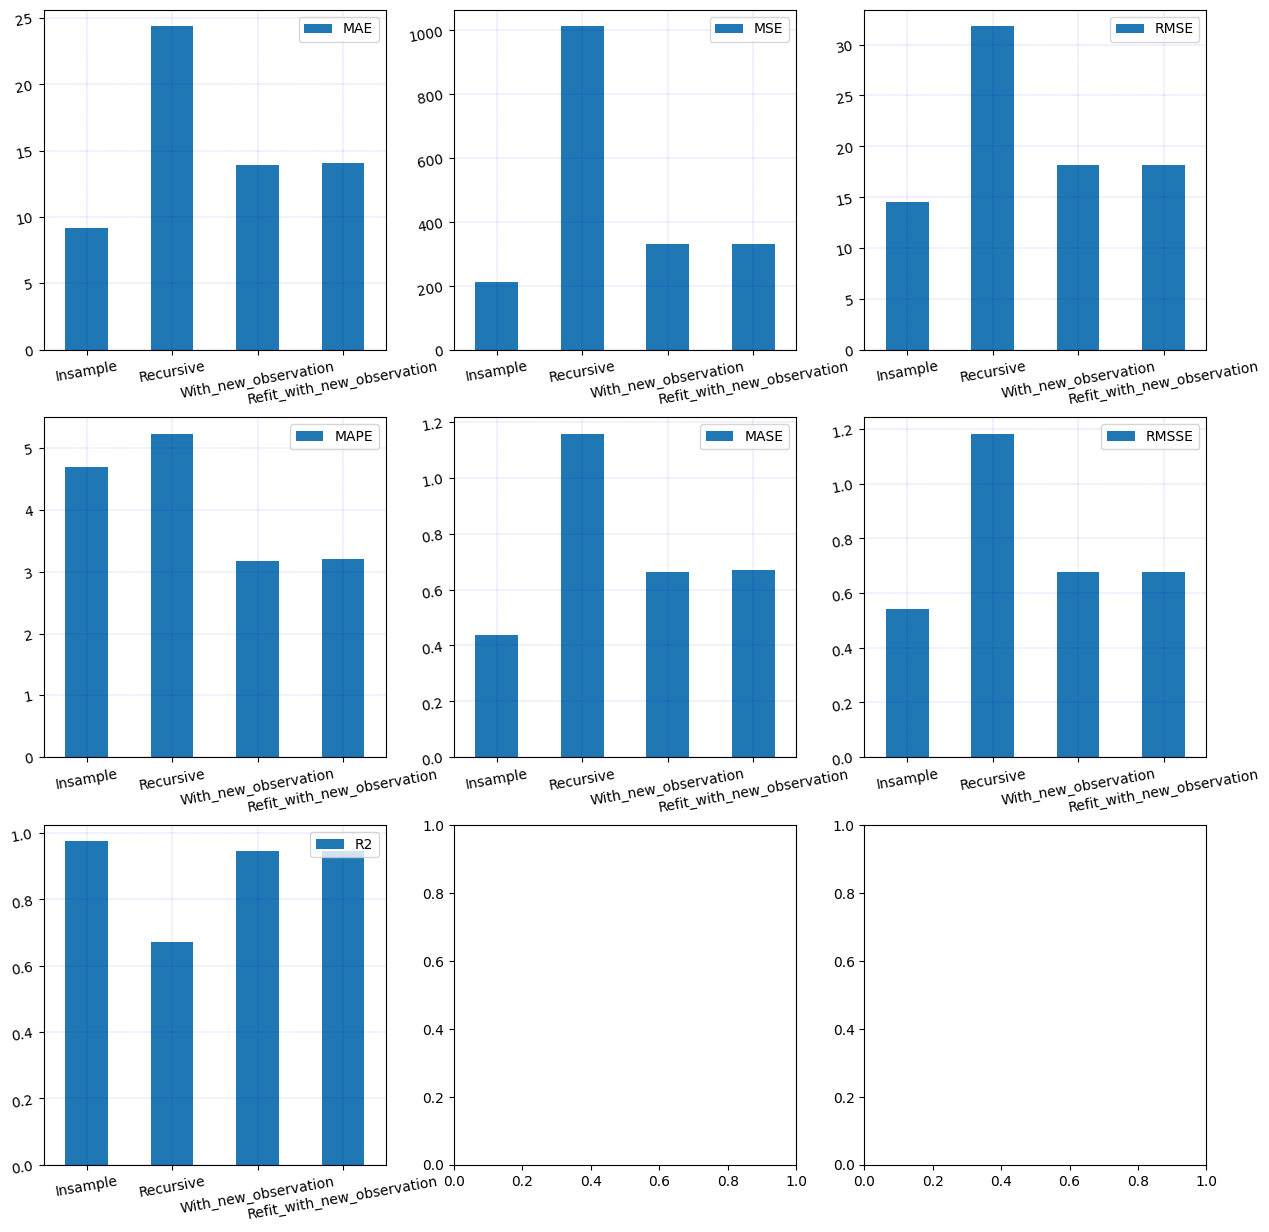

In [2]:
import datetime
df = pd.read_csv('data/AirPassengers.csv')
df.columns = ['Date','Number of Passengers']
data = pd.Series(data = df.iloc[:,1].to_numpy(), index=pd.to_datetime(df['Date']))
split_point = int(0.8 * data.shape[0])
y_train, y_validation = data[:split_point], data[split_point:]
SARIMAX_configs = {'order': (1, 1, 1), 'seasonal_order': (1, 0, 0, 12)}
prediction_step = 1
preds = validate_SARIMAX_on_split(y_train=y_train, y_validation=y_validation, prediction_step=prediction_step, SARIMAX_configs=SARIMAX_configs)
plot_SARIMAX_preds_on_split(y_train, y_validation, preds)
score_SARIMAX_preds_on_split(preds, y_validation, y_train, disp=True)
